# Import bibliotek

In [335]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score, precision_score, precision_recall_curve
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# Wczytanie danych

In [336]:
train_df = pd.read_parquet('train.parquet')
test_df = pd.read_parquet('test.parquet')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              20000 non-null  int64  
 1   Income           20000 non-null  float64
 2   CreditScore      17617 non-null  float64
 3   LoanAmount       20000 non-null  float64
 4   EmploymentYears  20000 non-null  int64  
 5   NumDependents    20000 non-null  int64  
 6   DebtToIncome     20000 non-null  float64
 7   EducationLevel   20000 non-null  int64  
 8   FavoriteColor    20000 non-null  object 
 9   Hobby            20000 non-null  object 
 10  Default          20000 non-null  int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 1.7+ MB


In [255]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 20000 to 24999
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  5000 non-null   float64
 1   Income               5000 non-null   float64
 2   CreditScore          5000 non-null   float64
 3   LoanAmount           5000 non-null   float64
 4   EmploymentYears      5000 non-null   int64  
 5   NumDependents        5000 non-null   int64  
 6   DebtToIncome         5000 non-null   float64
 7   EducationLevel       5000 non-null   int64  
 8   FavoriteColor        5000 non-null   object 
 9   Hobby                5000 non-null   object 
 10  Default              5000 non-null   int64  
 11  loan_to_income       5000 non-null   float64
 12  CreditScore_Missing  5000 non-null   int64  
dtypes: float64(6), int64(5), object(2)
memory usage: 507.9+ KB


# Eksploracja danych
W poniższej sekcji przeanalizowano zbiór treningowy danych. W pierwszej kolejności ze zbioru wykluczono dane niemające uzasadnienia biznesowego (FavoriteColor oraz Hobby).

In [337]:
train_df = train_df.drop(columns=['FavoriteColor', 'Hobby'])
null_counts = train_df.isnull().sum()
print("Number of null values in each column:\n{}".format(null_counts))

Number of null values in each column:
Age                   0
Income                0
CreditScore        2383
LoanAmount            0
EmploymentYears       0
NumDependents         0
DebtToIncome          0
EducationLevel        0
Default               0
dtype: int64


In [338]:
train_df.describe()

,Age,Income,CreditScore,LoanAmount,EmploymentYears,NumDependents,DebtToIncome,EducationLevel,Default
count,20000.000000,20000.000000,17617.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000
mean,44.959150,50004.431236,574.118635,20030.527761,19.369250,1.98985,0.502592,2.506150,0.343150
std,14.083764,15019.289666,159.041321,4992.059462,11.548159,1.41193,0.289153,1.116882,0.474773
min,21.000000,-16984.057953,300.000000,-2314.842635,0.000000,0.00000,0.000018,1.000000,0.000000
25%,33.000000,39716.883271,437.000000,16646.478319,9.000000,1.00000,0.251572,2.000000,0.000000
50%,45.000000,50084.103696,575.000000,20046.233086,19.000000,2.00000,0.501503,3.000000,0.000000
75%,57.000000,60285.318369,711.000000,23393.056940,29.000000,3.00000,0.753517,4.000000,1.000000
max,69.000000,117186.263765,849.000000,38800.776243,39.000000,4.00000,0.999984,4.000000,1.000000


W zbiorze treningowym braki wsytępują w kolumnie 'CreditScore' - 2383 wartości null. Jako że jest to jedna z najistotniejszych zmiennych w predykcji niewypłacalności, usunięcie wierszy z brakami (stanowiących ponad 10% danych treningowych) byłoby nieoptymalne. 

## Analiza danych numerycznych
Po usunięciu zmiennych nieistotnych z punktu widzenia bzinesowego, zbiór danych zawiera wyłącznie dane numeryczne.

In [339]:
num_cols = train_df.select_dtypes(exclude=['object']).columns
num_cols

Index(['Age', 'Income', 'CreditScore', 'LoanAmount', 'EmploymentYears',
       'NumDependents', 'DebtToIncome', 'EducationLevel', 'Default'],
      dtype='object')

### Analiza wartości odstających
yap yap yap o tym że boxploty i zscore

#### Analiza wykresów pudełkowych

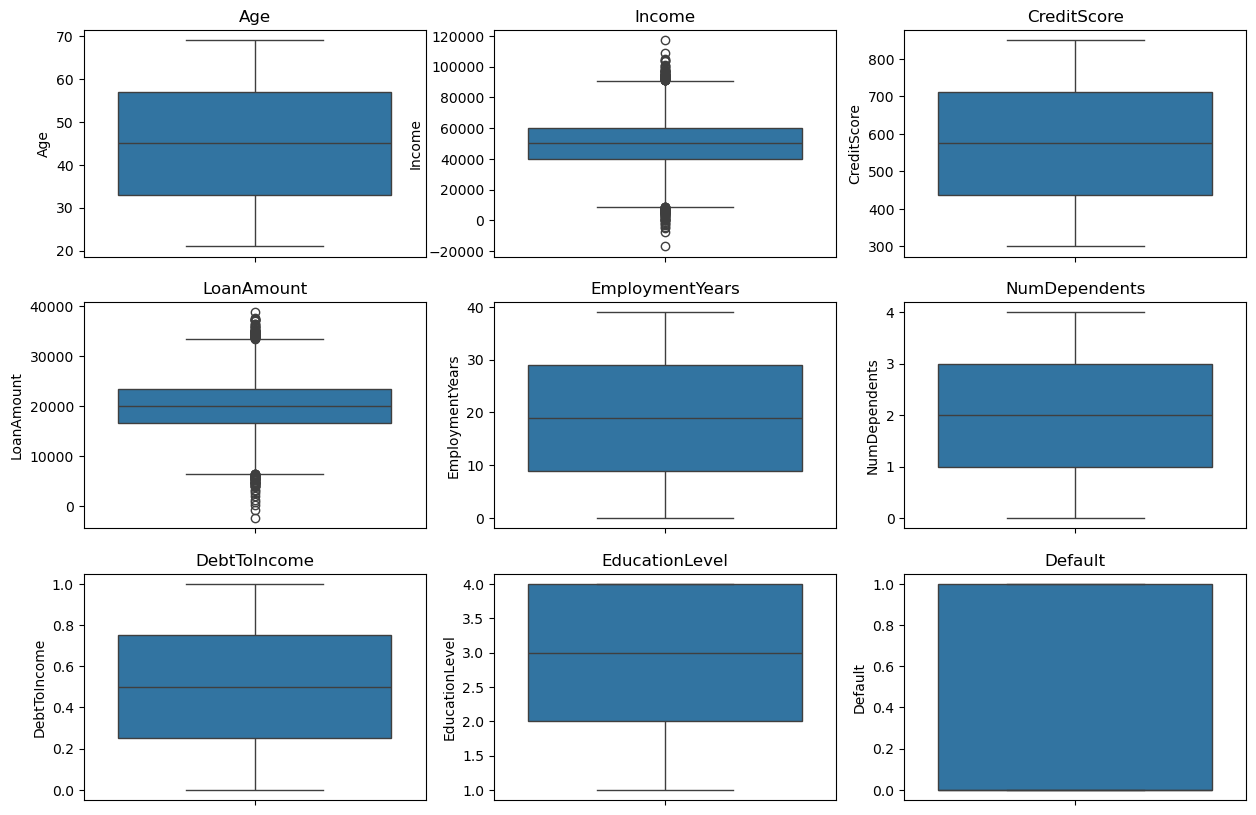

In [340]:
fig = plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.set_title(col)
    sns.boxplot(data=train_df[col], ax=ax)
plt.show()

#### Analiza Z-Score

In [341]:
#Przygotowanie tabeli
indeks = []
ilosc = []
minimum = []
maksimum = []
srednia = []
kwartyl_1 = []
mediana = []
kwartyl_3 = []
outliery = []
outliery_procent = []
outliery_zscore = []
outliery_procent_zscore = []

#Pętla przez kolumny numeryczne
for col in num_cols:
    indeks.append(col)
    ilosc.append(train_df[col].count())
    minimum.append(train_df[col].min())
    maksimum.append(train_df[col].max())
    srednia.append(train_df[col].mean())
    kwartyl_1.append(train_df[col].quantile(0.25))
    mediana.append(train_df[col].median())
    kwartyl_3.append(train_df[col].quantile(0.75))
    
    Q1 = train_df[col].quantile(0.25)
    Q3 = train_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_count = train_df[(train_df[col] < lower_bound) | (train_df[col] > upper_bound)][col].count()
    outliery.append(outlier_count)
    outliery_procent.append((outlier_count / train_df[col].count()) * 100)
    
    z_scores = (train_df[col] - train_df[col].mean()) / train_df[col].std()
    z_outlier_count = train_df[(z_scores < -3) | (z_scores > 3)][col].count()
    outliery_zscore.append(z_outlier_count)
    outliery_procent_zscore.append((z_outlier_count / train_df[col].count()) * 100)

tabela_statystyczna = pd.DataFrame({
    'Indeks': indeks,
    'Ilość': ilosc,
    'Minimum': minimum,
    'Maksimum': maksimum,
    'Średnia': srednia,
    'Kwartyl 1': kwartyl_1,
    'Mediana': mediana,
    'Kwartyl 3': kwartyl_3,
    'Liczba outlierów (IQR)': outliery,
    'Procent outlierów (IQR)': outliery_procent,
    'Liczba outlierów (Z-score)': outliery_zscore,
    'Procent outlierów (Z-score)': outliery_procent_zscore
})
tabela_statystyczna

,Indeks,Ilość,Minimum,Maksimum,Średnia,Kwartyl 1,Mediana,Kwartyl 3,Liczba outlierów (IQR),Procent outlierów (IQR),Liczba outlierów (Z-score),Procent outlierów (Z-score)
0,Age,20000,21.000000,69.000000,44.959150,33.000000,45.000000,57.000000,0,0.000,0,0.00
1,Income,20000,-16984.057953,117186.263765,50004.431236,39716.883271,50084.103696,60285.318369,129,0.645,54,0.27
2,CreditScore,17617,300.000000,849.000000,574.118635,437.000000,575.000000,711.000000,0,0.000,0,0.00
3,LoanAmount,20000,-2314.842635,38800.776243,20030.527761,16646.478319,20046.233086,23393.056940,135,0.675,50,0.25
4,EmploymentYears,20000,0.000000,39.000000,19.369250,9.000000,19.000000,29.000000,0,0.000,0,0.00
5,NumDependents,20000,0.000000,4.000000,1.989850,1.000000,2.000000,3.000000,0,0.000,0,0.00
6,DebtToIncome,20000,0.000018,0.999984,0.502592,0.251572,0.501503,0.753517,0,0.000,0,0.00
7,EducationLevel,20000,1.000000,4.000000,2.506150,2.000000,3.000000,4.000000,0,0.000,0,0.00
8,Default,20000,0.000000,1.000000,0.343150,0.000000,0.000000,1.000000,0,0.000,0,0.00


Analiza wykazała, że większość zmiennych ciągłych (takich jak Age, CreditScore, EmploymentYears, DebtToIncome) jest wolna od statystycznych wartości odstających według kryterium IQR oraz Z-score. Kluczowe problemy koncentrują się wokół zmiennych Income i LoanAmount, gdzie, choć odsetek outlierów jest niski, to wystąpiły nielogiczne wartości ujemne dla minimum. Korekta tych danych do wartości bezwzględnej jest niezbędna przed modelowaniem.

In [342]:
train_df['Income'] = train_df['Income'].abs()
train_df['LoanAmount'] = train_df['LoanAmount'].abs()

### Braki danych
W niniejszej sekcji podjęto próbę zadresowania problemu braku danych w kolumnie <i>CreditScore</i>

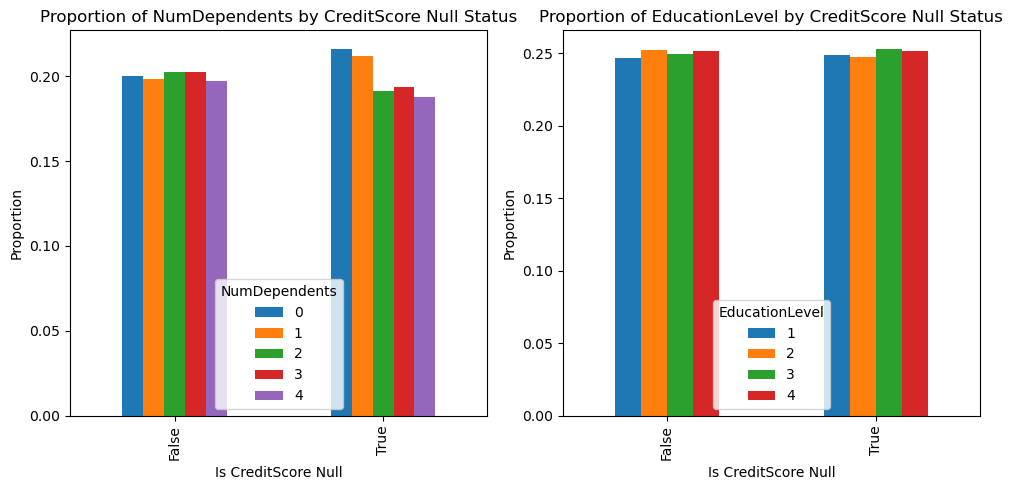

In [343]:
vars = ['NumDependents', 'EducationLevel']
fig = plt.figure(figsize=(10, 5))

for i, var in enumerate(vars):
    ax = fig.add_subplot(1, 2, i + 1)
    null_analysis = train_df.groupby(train_df['CreditScore'].isnull())[var].value_counts(normalize=True).unstack()
    null_analysis.plot(kind='bar', stacked=False, ax=ax)
    ax.set_title(f'Proportion of {var} by CreditScore Null Status')
    ax.set_xlabel('Is CreditScore Null')
    ax.set_ylabel('Proportion')

plt.tight_layout()
plt.show()


Analiza zależności braków danych w kolumnie CreditScore od zmiennych NumDependents, EducationLevel i zmiennej celu Default nie wykazała istotnych różnic w proporcjach. Rozkład poszczególnych kategorii w tych zmiennych był niemal identyczny zarówno dla klientów z brakującym, jak i z obecnym CreditScore. Wskazuje to, że braki te nie są silnie determinowane przez te czynniki.

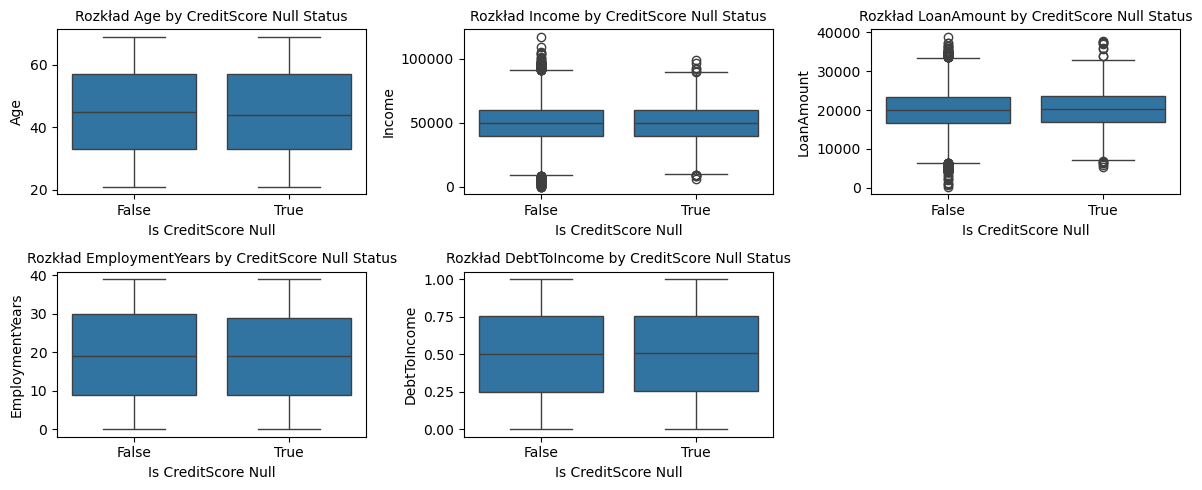

In [344]:
vars2 = ['Age', 'Income', 'LoanAmount', 'EmploymentYears', 'DebtToIncome']
fig = plt.figure(figsize=(12, 5))

for i, var in enumerate(vars2):
    ax = fig.add_subplot(2, 3, i + 1)
    sns.boxplot(
        x=train_df['CreditScore'].isnull(),
        y=train_df[var],
        ax=ax
    )
    ax.set_title(f'Rozkład {var} by CreditScore Null Status', fontsize=10)
    ax.set_xlabel('Is CreditScore Null')
    ax.set_ylabel(var)

plt.tight_layout()
plt.show()

Brak wyraźnych dowodów na zależność braków w kolumnie CreditScore od innych zaobserwowanych zmiennych sugeruje, że są one Missing Completely at Random (MCAR) lub wynikają z niezaobserwowanego czynnika, którego analiza wykracza poza zakres tego badania.
Z tego poowdu zdecydowano o imputacji braków medianą oraz dodaniu zmiennej będącej flagą braku danych.

In [345]:
train_df['CreditScore_Missing'] = train_df['CreditScore'].isnull().astype(int)
credit_score_median = train_df['CreditScore'].median()
train_df['CreditScore'] = train_df['CreditScore'].fillna(credit_score_median)

print(f"Zastosowana mediana do imputacji: {credit_score_median}")
print(f"Liczba braków po operacji: {train_df['CreditScore'].isnull().sum()}")

Zastosowana mediana do imputacji: 575.0
Liczba braków po operacji: 0


## Analiza zależności ze zmienną Default

### Analiza zmiennych numerycznych

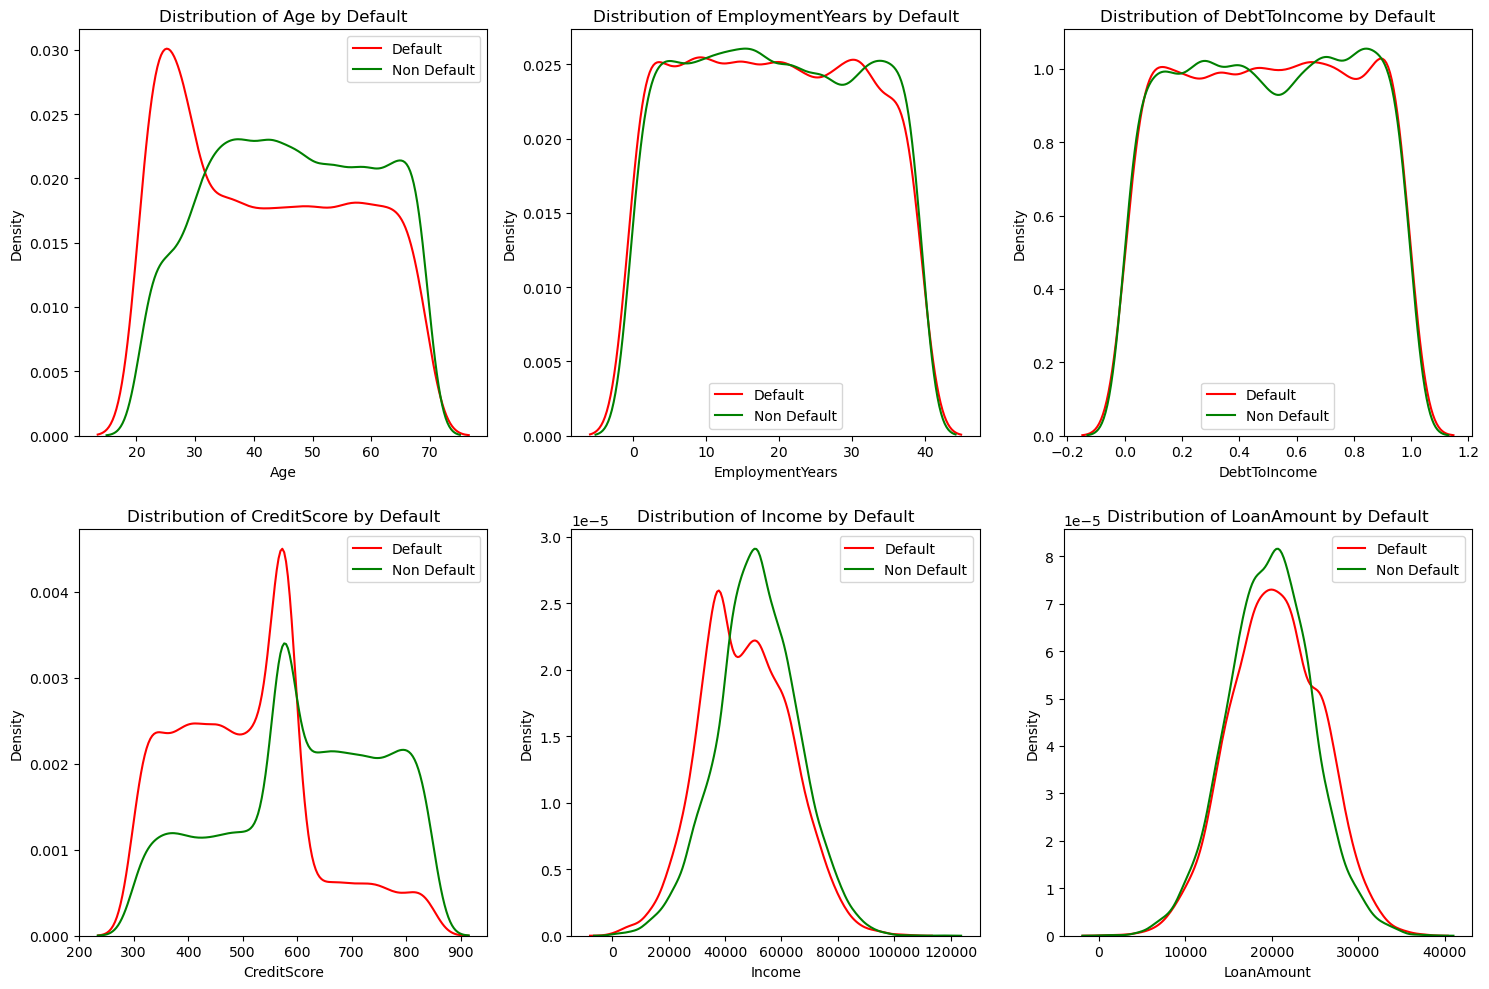

In [244]:
continuous_features = [
    'Age', 'EmploymentYears', 'DebtToIncome', 
    'CreditScore', 'Income', 'LoanAmount'
]

fig = plt.figure(figsize=(15, 10))
for i, var in enumerate(continuous_features):
    ax = fig.add_subplot(2, 3, i + 1)
    sns.kdeplot(train_df.loc[train_df['Default'] == 1, var], ax=ax, color="red", label="Default")
    sns.kdeplot(train_df.loc[train_df['Default'] == 0, var], ax=ax, color="green", label="Non Default")
    ax.set_title(f'Distribution of {var} by Default')
    ax.legend()
plt.tight_layout()
plt.show()

Wizualizacja gęstości pozwala na ocenę spearacji klas. Największe różnice zaobserwowano dla <i>CreditScore</i> - gęstość grupy <i>Default</i> jest wyraźnie wyższa w niskich zakresach punktowych (do 600), podczas gdy klienci wypłacalni dominują w wysokich zakresach (powyżej 650). Zauważalną zależność wykazuje także wiek klienta - osoby poniżej 30 roku życia statystycznie częściej trafiają do grupy 1, co może wynikać z niższej stabilności finansowej.
Ponadto zaobserwowano, że wyższa gęstość osób wypłacalnych przypada na wyższe przedziały dochodowe. Należy także zauważyć, że niewypłacalność częsciej towarzyszy wyższym kwotom zobowiązań.

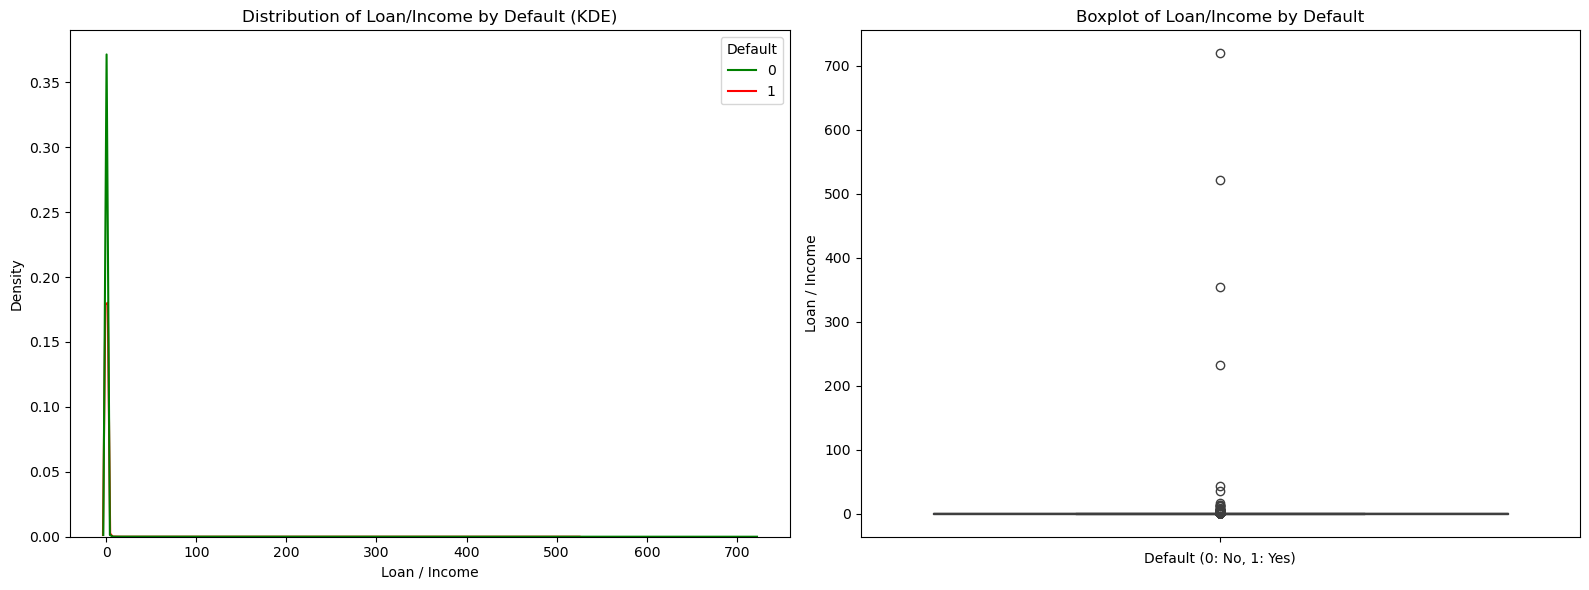

In [346]:
train_df['loan_to_income'] = train_df['LoanAmount'] / (train_df['Income'])

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.kdeplot(ax=axes[0], data=train_df, x='loan_to_income', hue='Default', 
            palette={0: 'green', 1: 'red'}, common_norm=False)
axes[0].set_title('Distribution of Loan/Income by Default (KDE)')
axes[0].set_xlabel('Loan / Income')
axes[0].set_ylabel('Density')

sns.boxplot(ax=axes[1], data=train_df, y='loan_to_income')
axes[1].set_title('Boxplot of Loan/Income by Default')
axes[1].set_xlabel('Default (0: No, 1: Yes)')
axes[1].set_ylabel('Loan / Income')

plt.tight_layout()
plt.show()

Przenalizowano współczynnik wnioskowanej kwoty pożyczki do rocznych dochodów - w zbiorze analogiczna istnieje zmienna <i>DebtToIncome</i> jednakże analizuje ona stosunek miesięcznych zobowiązań do miesięcznych dochodów.
Wykryto wartości odstające wskazujące na prawdopodobne błędy w danych wejściowych (np. dochód roczny na poziomie ok. 23 dolarów przy jednoczesnej wnioskowanej kwocie zadłużenia ok. 16120 dolarów).
Postanowiono o usunięciu danych z prawdopodobnym błędem.
Z tego powodu zdecydowano o zasosowaniu filtrowania z użyciem progu <i>loan_to_income</i> na poziomie 20.

In [347]:
print(f"Zdecydowano o usunięciu {len(train_df[train_df['loan_to_income'] > 20.0])} rekordów (anomalie).")
train_df = train_df[train_df['loan_to_income'] <= 20.0]


Zdecydowano o usunięciu 6 rekordów (anomalie).


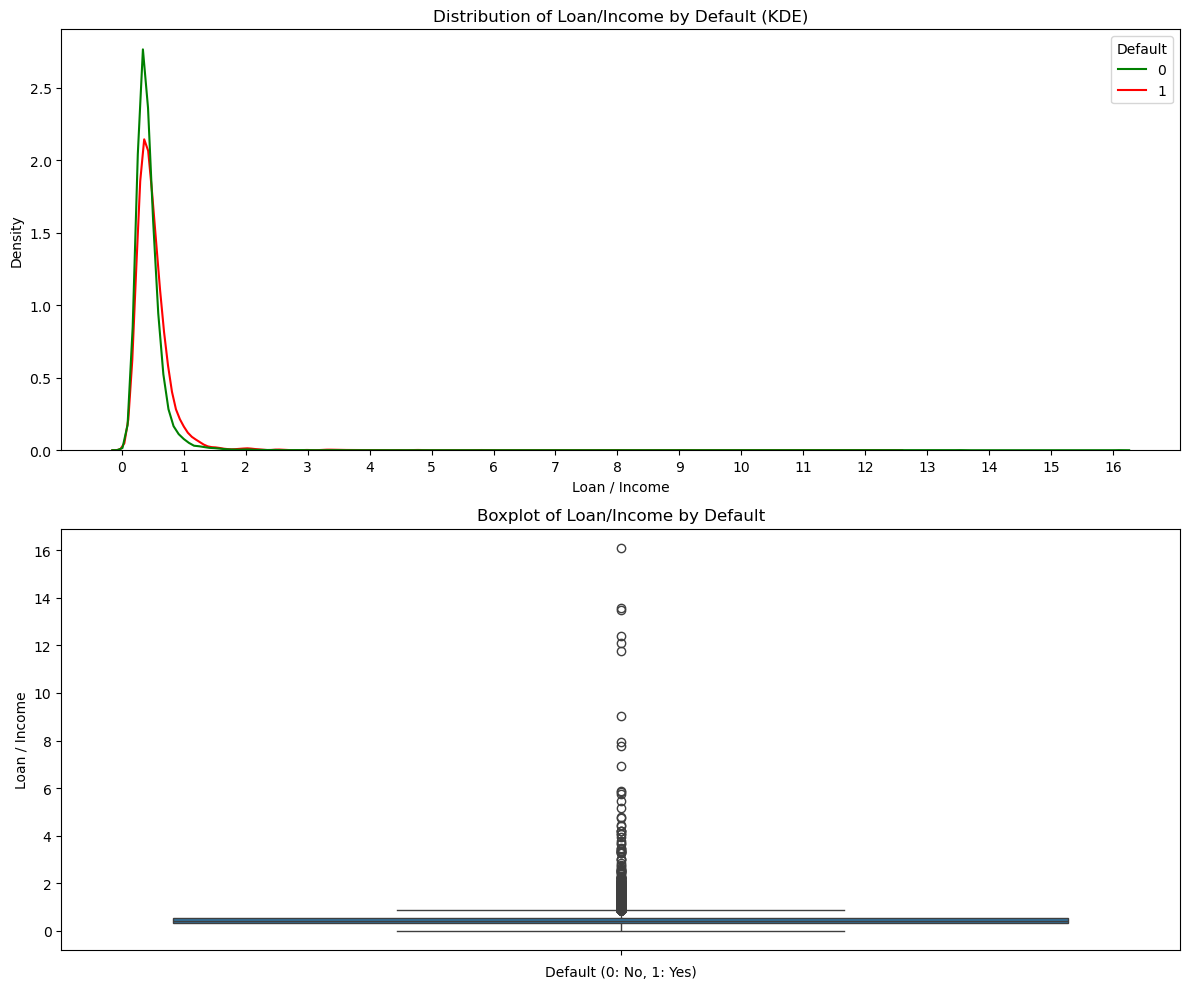

In [348]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
sns.kdeplot(ax=axes[0], data=train_df, x='loan_to_income', hue='Default', 
            palette={0: 'green', 1: 'red'}, common_norm=False)
axes[0].set_title('Distribution of Loan/Income by Default (KDE)')
axes[0].set_xlabel('Loan / Income')
axes[0].set_ylabel('Density')
axes[0].set_xticks(np.arange(0, train_df['loan_to_income'].max(), 1.0))

sns.boxplot(ax=axes[1], data=train_df, y='loan_to_income')
axes[1].set_title('Boxplot of Loan/Income by Default')
axes[1].set_xlabel('Default (0: No, 1: Yes)')
axes[1].set_ylabel('Loan / Income')

plt.tight_layout()
plt.show()

Ponownie przeanalizowano KDE oraz wykres pudełkowy dla uwtorzonej zmiennej - po usunięciu wartości najbardziej skrajnych.
Czerwona linia jest przesunięta w prawo względem linii oznaczającej brak Defaultu oraz ma "grubszy ogon". Oznacza to, że osoby, które nie spłacają kredytu, statystycznie częściej mają wyższy stosunek pożyczki do dochodu. 
Powyżej wartości <i>loan_to_income</i> 1.0 prawdopodobieństwo bycia w grupie Default rośnie.

### Analiza zmiennych kategorycznych

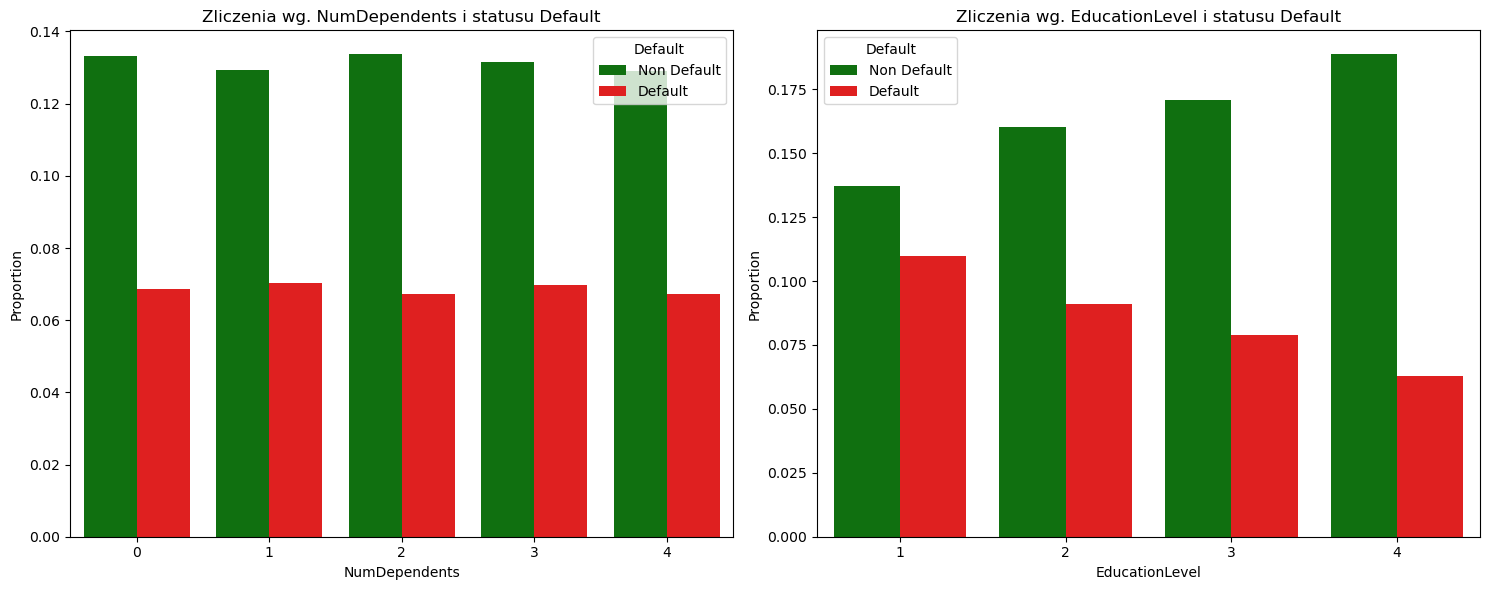

In [349]:
discrete_features = ['NumDependents', 'EducationLevel']
fig = plt.figure(figsize=(15, 6))

for i, var in enumerate(discrete_features):
    ax = fig.add_subplot(1, 2, i + 1)
    sns.countplot(
        x=var, hue='Default', data=train_df, stat= "proportion",
        ax=ax, palette={1: 'red', 0: 'green'}, order=sorted(train_df[var].unique())
    )
    ax.set_title(f'Zliczenia wg. {var} i statusu Default', fontsize=12)
    ax.set_xlabel(f'{var}')
    ax.set_ylabel('Proportion')
    ax.legend(title='Default', labels=['Non Default', 'Default'])

plt.tight_layout()
plt.show()

Poziom wykształcenia (EducationLevel) okazuje się kluczowym czynnikiem różnicującym klientów, ponieważ wraz z jego wzrostem wyraźnie zwiększa się proporcja osób spłacających kredyt przy jednoczesnym spadku udziału osób zalegających z płatnościami. Z kolei liczba osób na utrzymaniu (NumDependents) nie wykazuje istotnego wpływu na status kredytobiorcy, gdyż rozkład osób w grupie Default pozostaje na zbliżonym poziomie niezależnie od wielkości rodziny. W konsekwencji wykształcenie stanowi znacznie cenniejszą cechę dla modelu predykcyjnego niż liczba osób na utrzymaniu, która wydaje się neutralna w kontekście ryzyka kredytowego.

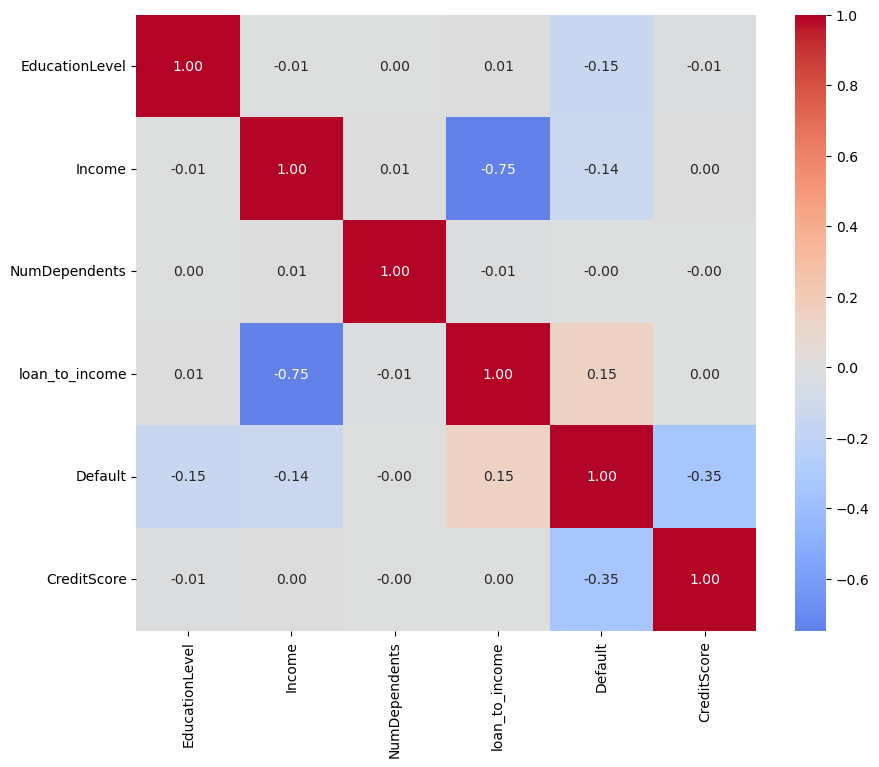

In [ ]:
corr_cols = ['EducationLevel', 'Income', 'NumDependents', 'loan_to_income', 'Default']
correlation_matrix = train_df[corr_cols].corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", center=0)
plt.show()

Wykształcenie (EducationLevel) jest najsilniejszym negatywnym predyktorem niewypłacalności, podczas gdy liczba osób na utrzymaniu (NumDependents) nie wykazuje istotnego wpływu na ryzyko kredytowe. Silna ujemna korelacja między dochodem a wskaźnikiem loan_to_income wynika bezpośrednio z ich wzajemnej zależności matematycznej i skutecznie obrazuje wzrost ryzyka przy niskich zarobkach. Oczyszczenie danych z ekstremalnych błędów pozwoliło potwierdzić, że wysoki stosunek pożyczki do dochodu jest kluczowym czynnikiem zwiększającym prawdopodobieństwo wystąpienia statusu Default.

# Wybór zmiennych do analizy

Ostateczny model powinien koncentrować się na zmiennych CreditScore, EducationLevel, Age oraz loan_to_income, ponieważ wykazują one najsilniejsze statystyczne powiązanie z ryzykiem niewypłacalności. Pomocniczo zachowano Income, LoanAmount oraz DebtToIncome dla zwiększenia precyzji algorytmu, podczas gdy cechy takie jak FavoriteColor, Hobby, NumDependents i EmploymentYears należy odrzucono ze względu na brak wartości predykcyjnej.

## Przygotowanie danych
### Przygotowanie zbioru treningowego
Zadecydowano o skalowaniu danych przy użyciu <i>RobustScaler</i>. Postanowiono o pozostawieniu zmiennej <i>EducationLevel</i> w pierwotnej formie (bez użycia np. OneHotEncoder), jako że jest ona cechą porządkową.

In [350]:
#features_to_scale = ['Age', 'CreditScore', 'Income', 'LoanAmount', 'loan_to_income']
#robust_scaler = RobustScaler()
#train_df[features_to_scale] = robust_scaler.fit_transform(train_df[features_to_scale])

final_features = [
    'Age', 'CreditScore', 'CreditScore_Missing', 
    'EducationLevel', 'loan_to_income', 'DebtToIncome'
]

X_train = train_df[final_features]
y_train = train_df['Default']

print("Dane zostały przeskalowane metodą RobustScaler.")

Dane zostały przeskalowane metodą RobustScaler.


### Przygotowanie zbioru testowego
Na zbiorze testowym wykonano następujące operacje:
- Wartości dochodu zostały przekształcone na dodatnie przy użyciu funkcji wartości bezwzględnej.
- Mimo braku faktycznych braków danych w tym zbiorze, utworzono kolumnę binarną CreditScore_Missing wypełnioną zerami, aby zachować identyczny układ cech jak w zbiorze treningowym.
- Ze względu na kompletną informację o ocenach kredytowych w zbiorze testowym, zrezygnowano z etapu uzupełniania wartości medianą.
- Wszystkie cechy numeryczne zostały przeskalowane przy użyciu metody .transform() na podstawie parametrów wyliczonych ze zbioru treningowego

In [259]:
test_df['Income'] = test_df['Income'].abs()
test_df['loan_to_income'] = test_df['LoanAmount'] / test_df['Income']

test_df['CreditScore_Missing'] = test_df['CreditScore'].isnull().astype(int)
test_df['CreditScore'] = test_df['CreditScore'].fillna(credit_score_median)

test_df[features_to_scale] = robust_scaler.transform(test_df[features_to_scale])
X_test = test_df[final_features]
y_test = test_df['Default']

In [351]:
print(f"Odestek dłużników w zbiorze treningowym: {y_train.mean():.4%}")
print(f"Odestek dłużników w zbiorze testowym: {y_test.mean():.4%}")

Odestek dłużników w zbiorze treningowym: 34.3103%
Odestek dłużników w zbiorze testowym: 35.2000%


# Budowa modelu
## Definicja modeli i paramterów
W celu zaaresowania niezbalansowanej próby danych zdecydowano o wykorzystaniu metody oversamplingu.

C:\Users\Maugorzata\AppData\Local\Temp\ipykernel_14080\3313144716.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=train_df[train_df['Default'] == 0], x=col, label='Spłacający (0)',
C:\Users\Maugorzata\AppData\Local\Temp\ipykernel_14080\3313144716.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=train_df[train_df['Default'] == 1], x=col, label='Dłużnicy (1)',
C:\Users\Maugorzata\AppData\Local\Temp\ipykernel_14080\3313144716.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=train_df[train_df['Default'] == 0], x=col, label='Spłacający (0)',
C:\Users\Maugorzata\AppData\Local\Temp\ipykernel_14080\33

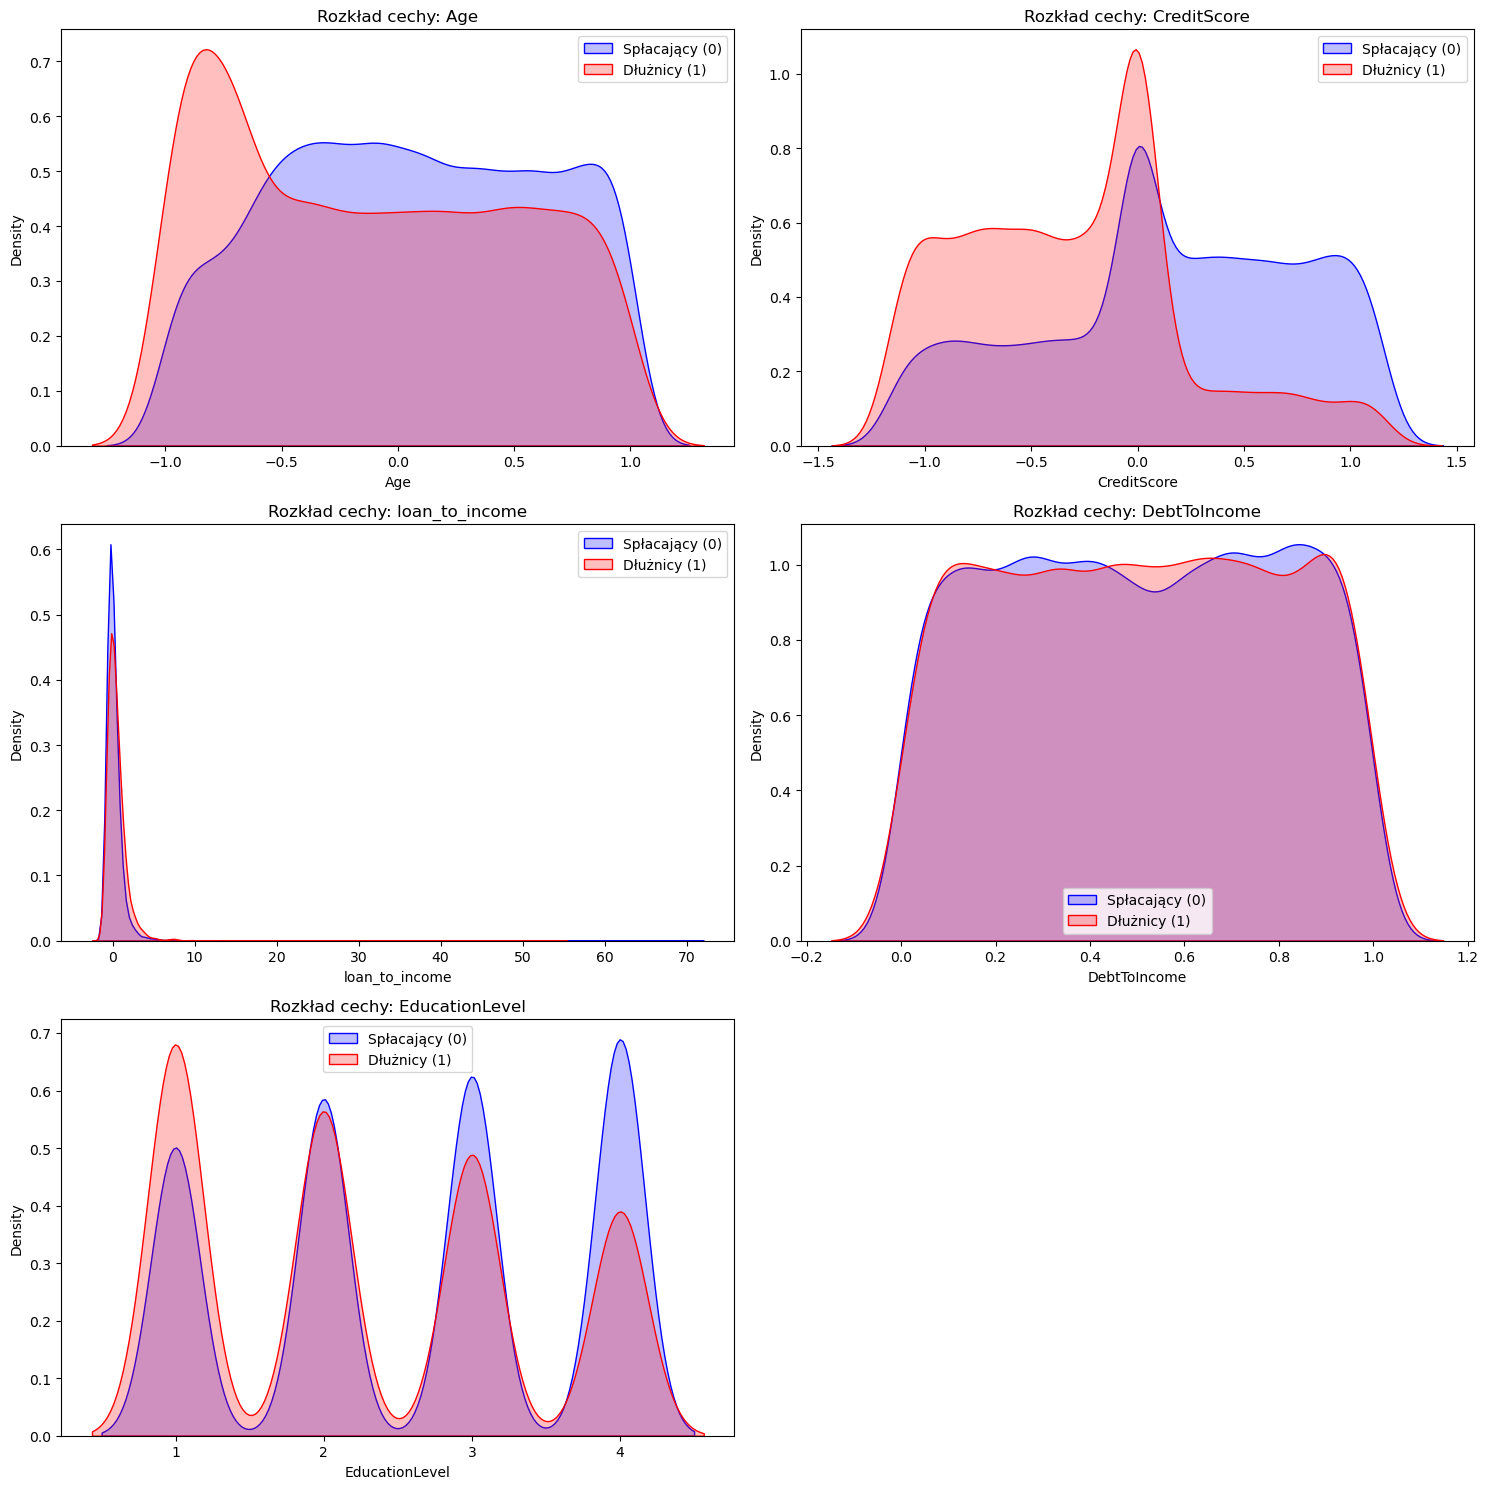

In [280]:
# 1. Lista cech do analizy
features_to_check = ['Age', 'CreditScore', 'loan_to_income', 'DebtToIncome', 'EducationLevel']

# 2. Tworzenie siatki wykresów
n_rows = (len(features_to_check) + 1) // 2
fig, axes = plt.subplots(n_rows, 2, figsize=(15, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(features_to_check):
    sns.kdeplot(data=train_df[train_df['Default'] == 0], x=col, label='Spłacający (0)', 
                ax=axes[i], shade=True, color='blue')
    sns.kdeplot(data=train_df[train_df['Default'] == 1], x=col, label='Dłużnicy (1)', 
                ax=axes[i], shade=True, color='red')
    
    axes[i].set_title(f'Rozkład cechy: {col}')
    axes[i].legend()

# Usunięcie pustego wykresu, jeśli liczba cech jest nieparzysta
if len(features_to_check) % 2 != 0:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

In [282]:
from scipy.stats import ks_2samp
ks_results = []

for col in features_to_check:
    # Pobieramy dane dla obu grup
    group0 = train_df[train_df['Default'] == 0][col]
    group1 = train_df[train_df['Default'] == 1][col]
    
    # Obliczamy test K-S
    stat, p_value = ks_2samp(group0, group1)
    
    ks_results.append({
        'Cecha': col,
        'Statystyka K-S': stat,
        'P-value': p_value
    })

# Prezentacja wyników
ks_df = pd.DataFrame(ks_results).sort_values(by='Statystyka K-S', ascending=False)
print(ks_df)

            Cecha  Statystyka K-S        P-value
1     CreditScore        0.386536   0.000000e+00
0             Age        0.164587  3.871466e-107
2  loan_to_income        0.140611   3.450502e-78
4  EducationLevel        0.133510   1.670208e-70
3    DebtToIncome        0.009995   7.549736e-01


<Axes: xlabel='Age', ylabel='CreditScore'>

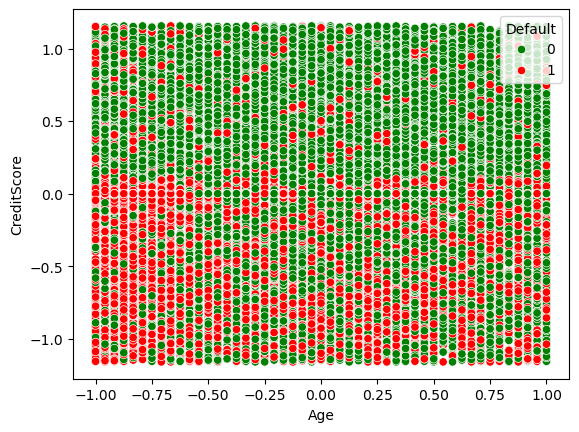

In [334]:
sns.scatterplot(data=train_df, x='Age', y='CreditScore', hue='Default', palette={0: 'green', 1: 'red'})

In [385]:
final_features_v2 = ['Age', 'CreditScore', 'EducationLevel', 'loan_to_income']

X_train_v2 = X_train[final_features_v2]
X_test_v2 = X_test[final_features_v2]

licznosci = [15000, 10000, 5000] # Skupiamy się na najbardziej obiecujących zakresach
opisy = ["Dolosowane 15 000", "Dolosowane 10 000", "Dolosowane 5 000"]

# Wybieramy modele, które wcześniej cokolwiek "złapały"
model_configs = {
    "Lasy losowe": (
        RandomForestClassifier(random_state=42), 
        {
            'n_estimators': [100, 200], 
            'max_depth': [8, 10, 15, None],
            'min_samples_leaf': [2, 10],
            'max_features': ['sqrt', None]
        }
    ),
    "XGBoost": (XGBClassifier(verbosity=0), {'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [4, 6, 8]}),
    "LogisticRegression": (LogisticRegression(max_iter=1000), {'C': [0.1, 1.0, 10.0]}),
}

results_v2 = []

for licz, opis in zip(licznosci, opisy):
    # Oversampling na odchudzonych cechach
    x_train_oversample = pd.concat([
        X_train_v2[y_train == 0],
        X_train_v2[y_train == 1].sample(licz, replace=True, random_state=42)
    ])
    y_train_oversample = np.concatenate([
        np.zeros(np.sum(y_train == 0)),
        np.ones(licz)
    ])
    
    for nazwa, (model, params) in model_configs.items():
        gs = GridSearchCV(model, params, cv=3, scoring='f1', n_jobs=-1)
        gs.fit(x_train_oversample, y_train_oversample)
        
        # Testujemy na X_test_v2
        best_m = gs.best_estimator_
        y_pred = best_m.predict(X_test_v2)
        
        results_v2.append({
            'Opis': opis,
            'Model': nazwa,
            'F1_Test': f1_score(y_test, y_pred),
            'Recall_Test': recall_score(y_test, y_pred),
            'Precision_Test': precision_score(y_test, y_pred),
            'Model_Object': best_m
        })

# Wyświetlenie tabeli wyników (dla standardowego progu 0.5)
results_v2_df = pd.DataFrame(results_v2)
print("--- Wyniki dla standardowego progu 0.5 ---")
print(results_v2_df.drop(columns='Model_Object').sort_values(by='F1_Test', ascending=False))

# --- OPTYMALIZACJA PROGU DLA NAJLEPSZEGO MODELU ---

# Wybieramy najlepszy model na podstawie F1 (np. Bagging Drzewo)
best_row = results_v2_df.sort_values(by='F1_Test', ascending=False).iloc[0]
best_model_obj = best_row['Model_Object']

print(f"\nOptymalizacja progu dla modelu: {best_row['Model']} ({best_row['Opis']})")

# Pobieramy prawdopodobieństwa
y_probs = best_model_obj.predict_proba(X_test_v2)[:, 1]

# Wyznaczamy krzywą Precision-Recall
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

# Szukamy progu dla maksymalnego F1
f1_scores_thresholds = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
best_idx = np.argmax(f1_scores_thresholds)
optimal_threshold = thresholds[best_idx]

# Finalna predykcja z nowym progiem
y_pred_final = (y_probs >= optimal_threshold).astype(int)

print(f"Wyznaczony optymalny próg: {optimal_threshold:.4f}")
print("\n--- FINALNY RAPORT PO OPTYMALIZACJI PROGU ---")
print(classification_report(y_test, y_pred_final))



--- Wyniki dla standardowego progu 0.5 ---
                Opis               Model   F1_Test  Recall_Test  \
1  Dolosowane 15 000             XGBoost  0.631120     0.739773   
2  Dolosowane 15 000  LogisticRegression  0.618326     0.753409   
4  Dolosowane 10 000             XGBoost  0.593906     0.609091   
0  Dolosowane 15 000         Lasy losowe  0.587262     0.605114   
5  Dolosowane 10 000  LogisticRegression  0.584963     0.603409   
3  Dolosowane 10 000         Lasy losowe  0.558957     0.523864   
7   Dolosowane 5 000             XGBoost  0.487505     0.382386   
6   Dolosowane 5 000         Lasy losowe  0.483178     0.383523   
8   Dolosowane 5 000  LogisticRegression  0.417058     0.302841   

   Precision_Test  
1        0.550296  
2        0.524318  
4        0.579459  
0        0.570434  
5        0.567611  
3        0.599090  
7        0.672328  
6        0.652805  
8        0.669598  

Optymalizacja progu dla modelu: XGBoost (Dolosowane 15 000)
Wyznaczony optymalny próg

In [387]:
confusion_matrix(y_test, y_pred_final)

array([[2088, 1152],
       [ 398, 1362]])

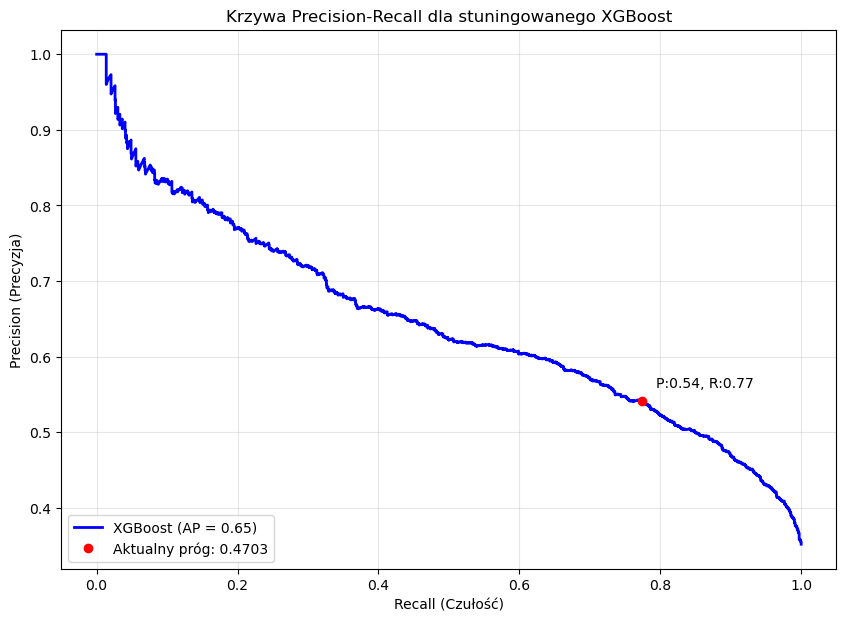

In [389]:
# 1. Pobieramy stuningowany model XGBoost z tabeli wyników
# Zakładamy, że to ostatni dodany model lub szukamy po opisie
from sklearn.metrics import precision_recall_curve, average_precision_score
mask_xgb = (results_v2_df['Model'] == 'XGBoost') & (results_v2_df['Opis'] == 'Dolosowane 15 000')
xgb_final = results_v2_df.loc[mask_xgb, 'Model_Object'].values[-1] # Bierzemy ostatni (stuningowany)

# 2. Pobieramy prawdopodobieństwa dla klasy 1
y_probs_xgb = xgb_final.predict_proba(X_test_v2)[:, 1]

# 3. Obliczamy punkty krzywej
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs_xgb)
avg_precision = average_precision_score(y_test, y_probs_xgb)

# 4. Wykres
plt.figure(figsize=(10, 7))
plt.plot(recalls, precisions, color='blue', lw=2, label=f'XGBoost (AP = {avg_precision:.2f})')

# Zaznaczamy Twój aktualny optymalny próg (0.4703)
# Szukamy indeksu progu najbliższego 0.4703
import numpy as np
idx = np.argmin(np.abs(thresholds - 0.4703))

plt.plot(recalls[idx], precisions[idx], 'ro', label=f'Aktualny próg: 0.4703')
plt.annotate(f'P:{precisions[idx]:.2f}, R:{recalls[idx]:.2f}', 
             (recalls[idx], precisions[idx]), textcoords="offset points", xytext=(10,10))

plt.xlabel('Recall (Czułość)')
plt.ylabel('Precision (Precyzja)')
plt.title('Krzywa Precision-Recall dla stuningowanego XGBoost')
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.show()

Ważność cech dla Lasów Losowych (15k oversampling):
          feature  importance
1     CreditScore    0.412205
3  loan_to_income    0.336954
0             Age    0.204832
2  EducationLevel    0.046008


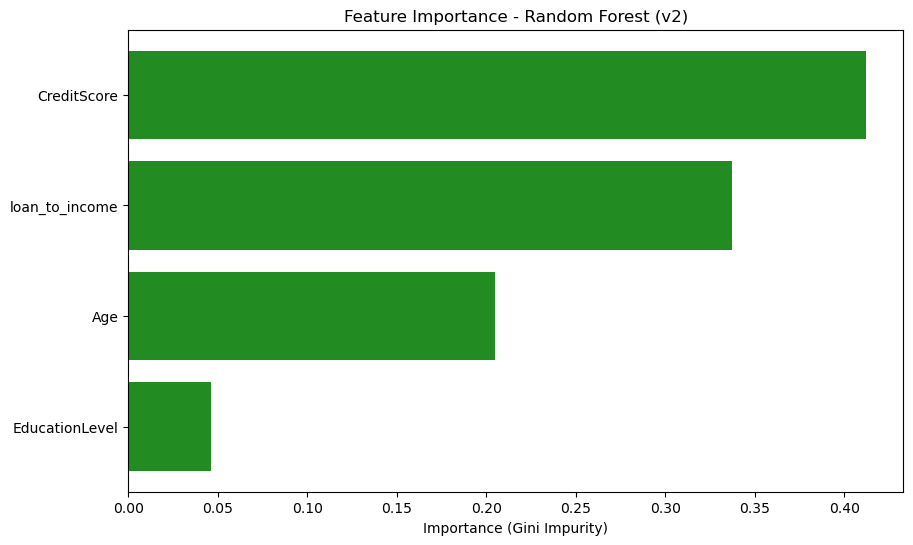

In [390]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Wybieramy model Lasy Losowe z opisu "Dolosowane 15 000" z Twojej tabeli results_v2_df
mask_rf = (results_v2_df['Model'] == 'Lasy losowe') & (results_v2_df['Opis'] == 'Dolosowane 15 000')
rf_model = results_v2_df.loc[mask_rf, 'Model_Object'].values[0]

# 2. Wyciągamy ważność cech
importances_rf = rf_model.feature_importances_
feature_names = final_features_v2 # Twoja lista: ['Age', 'CreditScore', 'EducationLevel', 'loan_to_income']

importance_rf_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances_rf
}).sort_values(by='importance', ascending=False)

print("Ważność cech dla Lasów Losowych (15k oversampling):")
print(importance_rf_df)

# 3. Wizualizacja
plt.figure(figsize=(10, 6))
plt.barh(importance_rf_df['feature'], importance_rf_df['importance'], color='forestgreen')
plt.gca().invert_yaxis()
plt.title('Feature Importance - Random Forest (v2)')
plt.xlabel('Importance (Gini Impurity)')
plt.show()

Ważność cech dla XGBoost (15k oversampling):
          feature  importance
1     CreditScore    0.373289
2  EducationLevel    0.252571
0             Age    0.208982
3  loan_to_income    0.165158


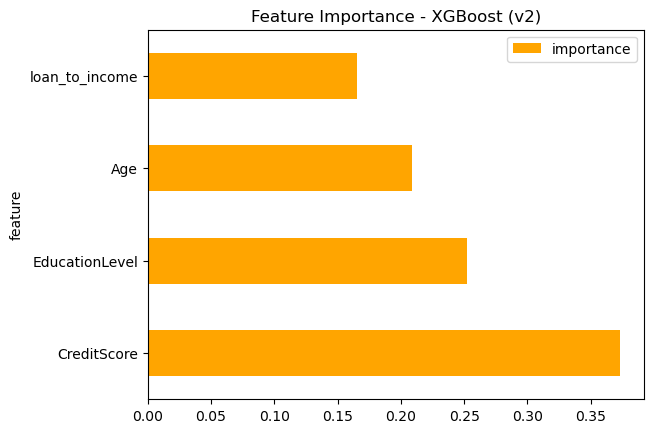

In [391]:
# 1. Wybieramy konkretny model z Twojej tabeli wyników
# Szukamy XGBoost z opisu "Dolosowane 15 000"
mask = (results_v2_df['Model'] == 'XGBoost') & (results_v2_df['Opis'] == 'Dolosowane 15 000')
xgb_model = results_v2_df.loc[mask, 'Model_Object'].values[0]

# 2. Wyciągamy ważność cech
importances = xgb_model.feature_importances_
feature_names = final_features_v2 # Używamy Twojej nowej listy 4 cech

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("Ważność cech dla XGBoost (15k oversampling):")
print(importance_df)

# Wizualizacja
importance_df.plot(kind='barh', x='feature', y='importance', color='orange')
plt.title('Feature Importance - XGBoost (v2)')
plt.show()

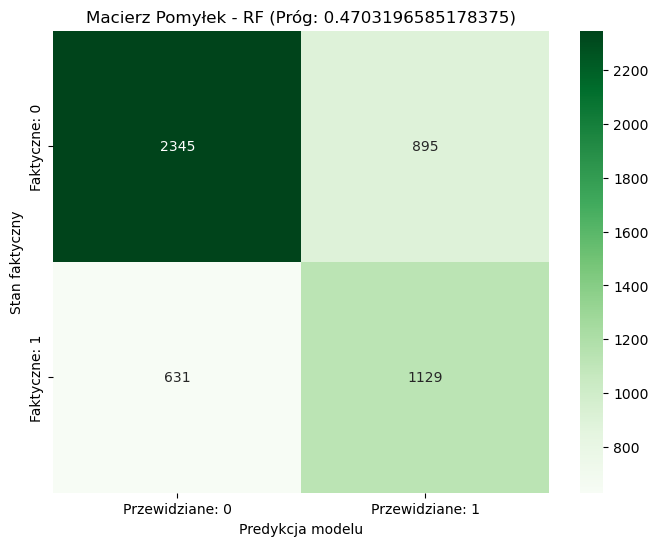

Poprawnie wykryte jedynki (TP): 1129
Błędnie uznane za zera (FN): 631 <- to są 'uciekające' okazje
Fałszywe alarmy (FP): 895 <- to są niepotrzebne akcje
Poprawnie odrzucone zera (TN): 2345


In [393]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 1. Pobieramy najlepszy model RF z Twojej tabeli wyników
mask_rf = (results_v2_df['Model'] == 'Lasy losowe') & (results_v2_df['Opis'] == 'Dolosowane 15 000')
rf_best = results_v2_df.loc[mask_rf, 'Model_Object'].values[0]

# 2. Generujemy prawdopodobieństwa dla zbioru testowego
y_probs_rf = rf_best.predict_proba(X_test_v2)[:, 1]


y_pred_optimal = (y_probs_rf >= optimal_threshold).astype(int)

# 4. Tworzymy macierz pomyłek
cm = confusion_matrix(y_test, y_pred_optimal)

# 5. Wizualizacja Macierzy Pomyłek
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Przewidziane: 0', 'Przewidziane: 1'],
            yticklabels=['Faktyczne: 0', 'Faktyczne: 1'])
plt.title(f'Macierz Pomyłek - RF (Próg: {optimal_threshold})')
plt.ylabel('Stan faktyczny')
plt.xlabel('Predykcja modelu')
plt.show()

# Dodatkowo wydrukujmy czyste statystyki
tn, fp, fn, tp = cm.ravel()
print(f"Poprawnie wykryte jedynki (TP): {tp}")
print(f"Błędnie uznane za zera (FN): {fn} <- to są 'uciekające' okazje")
print(f"Fałszywe alarmy (FP): {fp} <- to są niepotrzebne akcje")
print(f"Poprawnie odrzucone zera (TN): {tn}")